### 1) Initial Imports and loading the utils function. The dataset is used is <a href='https://www.kaggle.com/adityajn105/flickr8k'>Flickr 8k</a> from kaggle.<br>Custom dataset and dataloader is implemented in <a href="https://www.kaggle.com/mdteach/torch-data-loader-flicker-8k">this</a> notebook.

In [ ]:
# Mount google drive.
# Please add a shortcut for the shared folder to your own drive.
from google.colab import drive
drive.mount('/content/drive')

In [2]:
# System Libraries 
import os, glob
from glob import glob
import pickle
from sys import getsizeof

# Date and Time 
import datetime,time

# Data manipulation
import numpy as np
import pandas as pd
import collections, random, re
from collections import Counter


#Read/Display  images
from skimage import io
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import warnings
warnings.filterwarnings("ignore")

In [3]:
data_location = "drive/MyDrive/NLP-Project/data/"
image_path = data_location+"Images/"
caption_file = data_location+"captions.txt"

In [ ]:
#reading the text data 
import pandas as pd
# caption_file = data_location + '/captions.txt'
df = pd.read_csv(caption_file)
print("There are {} image to captions".format(len(df)))
df.head(7)

In [5]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

#select any index from the whole dataset 
#single image has 5 captions
#so, select indx as: 1,6,11,16...
data_idx = 11

#eg path to be plot: ../input/flickr8k/Images/1000268201_693b08cb0e.jpg
# image_path = data_location+"/Images/"+df.iloc[data_idx,0]
# img=mpimg.imread(image_path)
# plt.imshow(img)
# plt.show()

# #image consits of 5 captions,
# #showing all 5 captions of the image of the given idx 
# for i in range(data_idx,data_idx+5):
#     print("Caption:",df.iloc[i,1])

In [6]:
#imports 
import os
from collections import Counter
import spacy
import torch
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader,Dataset
import torchvision.transforms as T

from PIL import Image

#using spacy for the better text tokenization 
spacy_eng = spacy.load("en")

class Vocabulary:
    def __init__(self,freq_threshold):
        #setting the pre-reserved tokens int to string tokens
        self.itos = {0:"<PAD>",1:"<SOS>",2:"<EOS>",3:"<UNK>"}
        
        #string to int tokens
        #its reverse dict self.itos
        self.stoi = {v:k for k,v in self.itos.items()}
        
        self.freq_threshold = freq_threshold
        
    def __len__(self): return len(self.itos)
    
    @staticmethod
    def tokenize(text):
        return [token.text.lower() for token in spacy_eng.tokenizer(text)]
    
    def build_vocab(self, sentence_list):
        frequencies = Counter()
        idx = 4
        
        for sentence in tqdm(sentence_list):
            for word in self.tokenize(sentence):
                frequencies[word] += 1
                
                #add the word to the vocab if it reaches minum frequecy threshold
                if frequencies[word] == self.freq_threshold:
                    self.stoi[word] = idx
                    self.itos[idx] = word
                    idx += 1
    
    def numericalize(self,text):
        """ For each word in the text corresponding index token for that word form the vocab built as list """
        tokenized_text = self.tokenize(text)
        return [ self.stoi[token] if token in self.stoi else self.stoi["<UNK>"] for token in tokenized_text ]



In [7]:
class FlickrDataset(Dataset):
    """
    FlickrDataset
    """
    def __init__(self,root_dir,captions_file,transform=None,freq_threshold=5):
        self.root_dir = root_dir
        self.df = pd.read_csv(caption_file)
        self.transform = transform
        
        #Get image and caption colum from the dataframe
        self.imgs = self.df["image"]
        self.captions = self.df["caption"]
        
        #Initialize vocabulary and build vocab
        self.vocab = Vocabulary(freq_threshold)
        self.vocab.build_vocab(self.captions.tolist())
        
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self,idx):
        caption = self.captions[idx]
        img_name = self.imgs[idx]
        img_location = os.path.join(self.root_dir,img_name)
        img = Image.open(img_location).convert("RGB")
        
        #apply the transfromation to the image
        if self.transform is not None:
            img = self.transform(img)
        
        #numericalize the caption text
        caption_vec = []
        caption_vec += [self.vocab.stoi["<SOS>"]]
        caption_vec += self.vocab.numericalize(caption)
        caption_vec += [self.vocab.stoi["<EOS>"]]
        
        return img, torch.tensor(caption_vec)

#defining the transform to be applied
transforms = T.Compose([
    T.Resize(226),                     
    T.RandomCrop(224),                 
    T.ToTensor(),                               
    T.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))
])

def show_image(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated



100%|██████████| 40455/40455 [39:22<00:00, 17.13it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


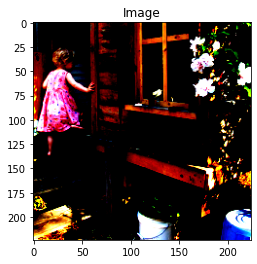

Token: tensor([  1,   4,  28,   8,   4, 195, 151,  17,  32,  67,   4, 353,  11, 711,
          8,  24,   3, 496,   5,   2])
Sentence:
['<SOS>', 'a', 'child', 'in', 'a', 'pink', 'dress', 'is', 'climbing', 'up', 'a', 'set', 'of', 'stairs', 'in', 'an', '<UNK>', 'way', '.', '<EOS>']


In [8]:
#testing the dataset class
dataset =  FlickrDataset(
    root_dir = data_location+"Images/",
    captions_file = data_location+"captions.txt",
    transform=transforms
)



img, caps = dataset[0]
show_image(img,"Image")
print("Token:",caps)
print("Sentence:")
print([dataset.vocab.itos[token] for token in caps.tolist()])

In [9]:
class CapsCollate:
    """
    Collate to apply the padding to the captions with dataloader
    """
    def __init__(self,pad_idx,batch_first=False):
        self.pad_idx = pad_idx
        self.batch_first = batch_first
    
    def __call__(self,batch):
        imgs = [item[0].unsqueeze(0) for item in batch]
        imgs = torch.cat(imgs,dim=0)
        
        targets = [item[1] for item in batch]
        targets = pad_sequence(targets, batch_first=self.batch_first, padding_value=self.pad_idx)
        return imgs,targets

# #writing the dataloader
# #setting the constants
# BATCH_SIZE = 256
# NUM_WORKER = 4

# #token to represent the padding
pad_idx = dataset.vocab.stoi["<PAD>"]

# data_loader = DataLoader(
#     dataset=dataset,
#     batch_size=BATCH_SIZE,
#     num_workers=NUM_WORKER,
#     shuffle=True,
#     collate_fn=CapsCollate(pad_idx=pad_idx,batch_first=True)
# )



In [10]:
np.random.seed(0)
indices = np.array([i*5 for i in range(8091)])
np.random.shuffle(indices)
split = int(len(indices)*0.8)
train_indices = indices[:split]
test_indices = indices[split:]

new = []
for item in train_indices:
    for i in range(1, 5):
        new.append(item+i)
print(len(train_indices), len(new))
train_indices = np.append(train_indices, np.array(new))

new = []
for item in test_indices:
    for i in range(1, 5):
        new.append(item+i)
test_indices = np.append(test_indices, np.array(new))

print(len(train_indices))
print(len(test_indices))


from torch.utils.data.sampler import SubsetRandomSampler

train_sampler = SubsetRandomSampler(train_indices)
dummy_sampler = SubsetRandomSampler(train_indices[:100])
test_sampler = SubsetRandomSampler(test_indices)

train_loader = torch.utils.data.DataLoader(dataset, batch_size=256,
    collate_fn=CapsCollate(pad_idx=pad_idx,batch_first=True), sampler=train_sampler)
dummy_loader = torch.utils.data.DataLoader(dataset, batch_size=256,
    collate_fn=CapsCollate(pad_idx=pad_idx,batch_first=True), sampler=dummy_sampler)
test_loader = torch.utils.data.DataLoader(dataset, batch_size=1, collate_fn=CapsCollate(pad_idx=pad_idx,batch_first=True), sampler=test_sampler)
# train_dataset = []
# test_dataset = []
# for idx in train_indices:
#     train_dataset.append(dataset[idx: idx+5])
# for idx in test_indices:
#     test_dataset.append(dataset[idx: idx+5])



6472 25888
32360
8095


In [11]:
test_loader_1 = torch.utils.data.DataLoader(dataset, batch_size=1, collate_fn=CapsCollate(pad_idx=pad_idx,batch_first=True), sampler=sorted(test_indices))

In [12]:
#vocab_size
vocab_size = len(dataset.vocab)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [13]:
# #location of the training data 
# data_location =  "../input/flickr8k"
# #copy dataloader
# !cp ../input/data-loader/data_loader.py .

#imports
import numpy as np
import torch
from torch.utils.data import DataLoader,Dataset
import torchvision.transforms as T

# #custom imports 
# from data_loader import FlickrDataset,get_data_loader

### 2) **<b>Implementing the Helper function to plot the Tensor image**

### 3) Defining the Model Architecture

Model is seq2seq model. In the **encoder** pretrained ResNet model is used to extract the features. Decoder, is the implementation of the Bahdanau Attention Decoder. In the decoder model **LSTM cell**.

In [14]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision.models as models
from torch.utils.data import DataLoader,Dataset
import torchvision.transforms as T

In [15]:
class EncoderCNN(nn.Module):
    def __init__(self):
        super(EncoderCNN, self).__init__()
        resnet = models.resnet50(pretrained=True)
        for param in resnet.parameters():
            param.requires_grad_(False)
        
        modules = list(resnet.children())[:-2]
        self.resnet = nn.Sequential(*modules)
        

    def forward(self, images):
        features = self.resnet(images)                                    #(batch_size,2048,7,7)
        features = features.permute(0, 2, 3, 1)                           #(batch_size,7,7,2048)
        features = features.view(features.size(0), -1, features.size(-1)) #(batch_size,49,2048)
        return features


In [16]:
#Bahdanau Attention
class Attention(nn.Module):
    def __init__(self, encoder_dim,decoder_dim,attention_dim):
        super(Attention, self).__init__()
        
        self.attention_dim = attention_dim
        
        self.W = nn.Linear(decoder_dim,attention_dim)
        self.U = nn.Linear(encoder_dim,attention_dim)
        
        self.A = nn.Linear(attention_dim,1)
        
        
        
        
    def forward(self, features, hidden_state):
        u_hs = self.U(features)     #(batch_size,num_layers,attention_dim)
        w_ah = self.W(hidden_state) #(batch_size,attention_dim)
        
        combined_states = torch.tanh(u_hs + w_ah.unsqueeze(1)) #(batch_size,num_layers,attemtion_dim)
        
        attention_scores = self.A(combined_states)         #(batch_size,num_layers,1)
        attention_scores = attention_scores.squeeze(2)     #(batch_size,num_layers)
        
        
        alpha = F.softmax(attention_scores,dim=1)          #(batch_size,num_layers)
        
        attention_weights = features * alpha.unsqueeze(2)  #(batch_size,num_layers,features_dim)
        attention_weights = attention_weights.sum(dim=1)   #(batch_size,num_layers)
        
        return alpha,attention_weights

class RawAttention(nn.Module):
    def __init__(self, embed_size, decoder_dim, attention_dim, dropout_p=0.1):
        super(RawAttention, self).__init__()
        
        self.attention_dim = attention_dim
        
        self.W1 = nn.Linear(embed_size,attention_dim)
        self.W2 = nn.Linear(decoder_dim,attention_dim)
        
        self.A = nn.Linear(attention_dim,49)
        self.dropout = nn.Dropout(dropout_p)
        
        
        
        
    def forward(self, features, hidden_state, embed):
        embed = embed.view(embed.shape[0], 1, -1)
        embed = self.dropout(embed)
        # print(embed.shape)
        e_hs = self.W1(embed)     #(batch_size,1,attention_dim)
        w_ah = self.W2(hidden_state) #(batch_size,attention_dim)
        
        combined_states = torch.tanh(e_hs + w_ah.unsqueeze(1)) #(batch_size,1,attention_dim)
        
        attention_scores = self.A(combined_states).permute(0, 2, 1)         #(batch_size,num_layers,1)
        attention_scores = attention_scores.squeeze(2)     #(batch_size,num_layers)
        
        
        alpha = F.softmax(attention_scores,dim=1)          #(batch_size,num_layers)
        
        attention_weights = features * alpha.unsqueeze(2)  #(batch_size,num_layers,features_dim)
        attention_weights = attention_weights.sum(dim=1)   #(batch_size,num_layers)
        
        return alpha,attention_weights
        

In [17]:
#Attention Decoder
class DecoderRNN(nn.Module):
    def __init__(self,embed_size, vocab_size, attention_dim,encoder_dim,decoder_dim,drop_prob=0.3):
        super().__init__()
        
        #save the model param
        self.vocab_size = vocab_size
        self.attention_dim = attention_dim
        self.decoder_dim = decoder_dim
        
        self.embedding = nn.Embedding(vocab_size,embed_size)
        # Self Attention
        self.attention = Attention(encoder_dim,decoder_dim,attention_dim)
        # Raw Attention
        # self.attention = RawAttention(embed_size,decoder_dim,attention_dim)
        
        
        self.init_h = nn.Linear(encoder_dim, decoder_dim)  
        self.init_c = nn.Linear(encoder_dim, decoder_dim)  
        self.lstm_cell = nn.LSTMCell(embed_size+encoder_dim,decoder_dim,bias=True)
        self.f_beta = nn.Linear(decoder_dim, encoder_dim)
        
        
        self.fcn = nn.Linear(decoder_dim,vocab_size)
        self.drop = nn.Dropout(drop_prob)
        
        
    
    def forward(self, features, captions):
        
        #vectorize the caption
        embeds = self.embedding(captions)
        
        # Initialize LSTM state
        h, c = self.init_hidden_state(features)  # (batch_size, decoder_dim)
        
        #get the seq length to iterate
        seq_length = len(captions[0])-1 #Exclude the last one
        batch_size = captions.size(0)
        num_features = features.size(1)
        
        preds = torch.zeros(batch_size, seq_length, self.vocab_size).to(device)
        alphas = torch.zeros(batch_size, seq_length,num_features).to(device)
                
        for s in range(seq_length):
            # Self Attention
            alpha,context = self.attention(features, h)
            # Raw Attention
            # alpha,context = self.attention(features, h, embeds[:, s])
            lstm_input = torch.cat((embeds[:, s], context), dim=1)
            h, c = self.lstm_cell(lstm_input, (h, c))
                    
            output = self.fcn(self.drop(h))
            
            preds[:,s] = output
            alphas[:,s] = alpha  
        
        
        return preds, alphas
    
    def generate_caption(self,features,max_len=20,vocab=None):
        # Inference part
        # Given the image features generate the captions
        
        batch_size = features.size(0)
        h, c = self.init_hidden_state(features)  # (batch_size, decoder_dim)
        
        alphas = []
        
        #starting input
        word = torch.tensor(vocab.stoi['<SOS>']).view(1,-1).to(device)
        embeds = self.embedding(word)

        
        captions = []
        
        for i in range(max_len):
            # Self Attention
            alpha,context = self.attention(features, h)
            # Raw Attention
            # alpha,context = self.attention(features, h, embeds[:, 0])
            
            
            #store the apla score
            alphas.append(alpha.cpu().detach().numpy())
            
            lstm_input = torch.cat((embeds[:, 0], context), dim=1)
            h, c = self.lstm_cell(lstm_input, (h, c))
            output = self.fcn(self.drop(h))
            output = output.view(batch_size,-1)
        
            
            #select the word with most val
            predicted_word_idx = output.argmax(dim=1)
            
            #save the generated word
            captions.append(predicted_word_idx.item())
            
            #end if <EOS detected>
            if vocab.itos[predicted_word_idx.item()] == "<EOS>":
                break
            
            #send generated word as the next caption
            embeds = self.embedding(predicted_word_idx.unsqueeze(0))
        
        #covert the vocab idx to words and return sentence
        return [vocab.itos[idx] for idx in captions],alphas
    
    
    def init_hidden_state(self, encoder_out):
        mean_encoder_out = encoder_out.mean(dim=1)
        h = self.init_h(mean_encoder_out)  # (batch_size, decoder_dim)
        c = self.init_c(mean_encoder_out)
        return h, c


In [18]:
class EncoderDecoder(nn.Module):
    def __init__(self,embed_size, vocab_size, attention_dim,encoder_dim,decoder_dim,drop_prob=0.3):
        super().__init__()
        self.encoder = EncoderCNN()
        self.decoder = DecoderRNN(
            embed_size=embed_size,
            vocab_size = len(dataset.vocab),
            attention_dim=attention_dim,
            encoder_dim=encoder_dim,
            decoder_dim=decoder_dim
        )
        
    def forward(self, images, captions):
        features = self.encoder(images)
        outputs = self.decoder(features, captions)
        return outputs




```
# This is formatted as code
```

### 4) Setting Hyperparameter and Init the model

In [19]:
#Hyperparams
embed_size=300
vocab_size = len(dataset.vocab)
attention_dim=256
encoder_dim=2048
decoder_dim=512
learning_rate = 3e-4


In [20]:
#init model
model = EncoderDecoder(
    embed_size=300,
    vocab_size = len(dataset.vocab),
    attention_dim=256,
    encoder_dim=2048,
    decoder_dim=512
).to(device)

criterion = nn.CrossEntropyLoss(ignore_index=dataset.vocab.stoi["<PAD>"])
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


In [21]:
#helper function to save the model
def save_model(model,num_epochs):
    model_state = {
        'num_epochs':num_epochs,
        'embed_size':embed_size,
        'vocab_size':len(dataset.vocab),
        'attention_dim':attention_dim,
        'encoder_dim':encoder_dim,
        'decoder_dim':decoder_dim,
        'state_dict':model.state_dict()
    }
    print("Saving.......")
    torch.save(model_state,'drive/MyDrive/attention_model/raw_attention_model_state.pth')

In [ ]:
!ls drive/MyDrive/attention_model

attention_model_state_trial.pth


In [ ]:
!mv attention_model_state.pth drive/MyDrive/attention_model/.

mv: cannot stat 'attention_model_state.pth': No such file or directory


## 5) Training Job from above configs

In [ ]:
num_epochs = 10
print_every = 20
# model.load_state_dict(torch.load("drive/MyDrive/attention_model_state.pth")["state_dict"])
# model.load_state_dict(torch.load("drive/MyDrive/attention_model/raw_attention_model_state.pth")["state_dict"])
for epoch in range(1,num_epochs+1):
    # for idx, (image, captions) in enumerate(iter(dummy_loader)):   
    for idx, (image, captions) in enumerate(iter(train_loader)):
        print("At batch number ", idx+1)
        image,captions = image.to(device),captions.to(device)

        # Zero the gradients.
        optimizer.zero_grad()

        # Feed forward
        outputs,attentions = model(image, captions)

        # Calculate the batch loss.
        targets = captions[:,1:]
        loss = criterion(outputs.view(-1, vocab_size), targets.reshape(-1))
        
        # Backward pass.
        loss.backward()

        # Update the parameters in the optimizer.
        optimizer.step()

        if (idx+1)%print_every == 0:
            print("Epoch: {} loss: {:.5f}".format(epoch,loss.item()))
            
            
        #     #generate the caption
        #     model.eval()
        #     with torch.no_grad():
        #         dataiter = iter(test_loader)
        #         img,_ = next(dataiter)
        #         features = model.encoder(img[0:1].to(device))
        #         caps,alphas = model.decoder.generate_caption(features,vocab=dataset.vocab)
        #         caption = ' '.join(caps)
        #         show_image(img[0],title=caption)
                
        #     model.train()
        
    #save the latest model
    save_model(model,epoch)

In [36]:
from nltk.translate.bleu_score import corpus_bleu
from tqdm import tqdm

model.load_state_dict(torch.load("drive/MyDrive/attention_model_state.pth")["state_dict"])
# model.load_state_dict(torch.load("drive/MyDrive/attention_model/raw_attention_model_state.pth")["state_dict"])


references = []
# hypothesis = []
weights = [(1.0), (.5, .5), (.33, .33, .33), (1/4.0, 1/4.0, 1/4.0, 1/4.0)]
# refer = {}
# hyp = {}
h1 = []
h2 = []
h3 = []
h4 = []
h5 = []
for idx, (iimage, captions) in enumerate(iter(test_loader_1)):
    if idx % 1000 == 0:
        print(idx)
    image,captions = iimage.to(device),captions.to(device)
    model.eval()
    with torch.no_grad():
        features = model.encoder(image.to(device))
        caps,alphas = model.decoder.generate_caption(features,vocab=dataset.vocab)
        caps = caps[:-1]
        gt = [dataset.vocab.itos[item] for item in captions.tolist()[0]]
        gt = gt[1:len(gt)-1]
        if idx%5 == 0:
            references.append([gt])
        else:
            references[-1] = references[-1] + [gt]
        if idx%5 == 0:
            h1.append(caps)
        elif idx%5 == 1:
            h2.append(caps)
        elif idx%5 == 2:
            h3.append(caps)
        elif idx%5 == 3:
            h4.append(caps)
        else:
            h5.append(caps)
        # print(gt)
        # print(caps)
        # if iimage not in refer:
        #     refer[iimage] = [gt]
        # else:
        #     print("here")
        #     refer[iimage].append(gt)

        # if iimage not in hyp:
        #     hyp[iimage] = caps
        
        # references.append([gt])
        # hypothesis.append([caps])
# print(corpus_bleu(references, hypothesis, weights))





0
1000
2000
3000
4000
5000
6000
7000
8000


In [37]:
weights = [[1.0], (.5, .5), (.33, .33, .33), (1/4.0, 1/4.0, 1/4.0, 1/4.0)]


In [ ]:
#BLEU Scores.
for weight in weights:
    print(idx+1, weight)
    print(corpus_bleu(references, h1, weight))
    print(corpus_bleu(references, h2, weight))
    print(corpus_bleu(references, h3, weight))
    print(corpus_bleu(references, h4, weight))
    print(corpus_bleu(references, h5, weight))

In [1]:
class BeamSearchNode(object):
    def __init__(self, hiddenstate, previousNode, wordId, logProb, length):
        '''
        :param hiddenstate:
        :param previousNode:
        :param wordId:
        :param logProb:
        :param length:
        '''
        self.h = hiddenstate
        self.prevNode = previousNode
        self.wordid = wordId
        self.logp = logProb
        self.leng = length

    def eval(self, alpha=0.7):
        reward = 0
        # Add here a function for shaping a reward

        return self.logp / math.pow(self.leng, alpha)

def predict_beam(model, sentence, k=5, max_length=100):
    """Make predictions for the given inputs using beam search.
    
    Args:
        model: A sequence-to-sequence model.
        sentence: An input sentence, represented as string.
        k: The size of the beam.
        max_length: The maximum length at which to truncate outputs in order to
            avoid non-terminating inference.
    
    Returns:
        A list of k beam predictions. Each element in the list should be a string
        corresponding to one of the top k predictions for the corresponding input,
        sorted in descending order by its final score.
    """

    # Implementation tip: once an eos_token has been generated for any beam, 
    # remove its subsequent predictions from that beam by adding a small negative 
    # number like -1e9 to the appropriate logits. This will ensure that the 
    # candidates are removed from the beam, as its probability will be very close
    # to 0. Using this method, uou will be able to reuse the beam of an already 
    # finished candidate

    # Implementation tip: while you are encouraged to keep your tensor dimensions
    # constant for simplicity (aside from the sequence length), some special care
    # will need to be taken on the first iteration to ensure that your beam
    # doesn't fill up with k identical copies of the same candidate.
    
    # You are welcome to tweak alpha
    alpha = 0.7
    model.eval()
    
    # YOUR CODE HERE
    ...
    x = torch.LongTensor(vocab.get_ids_from_sentence(sentence)).to(device)
    x = x.view(-1, 1)
    encoder_output, encoder_mask, last_hidden = model.encode(x)
    decoder_input = torch.LongTensor([bos_id]).view(-1,1).to(device)
    output = ''
    endnodes = []
    # for i in range(max_length):
    node = BeamSearchNode(last_hidden, None, decoder_input, 0, 1)
    nodes = [(-node.eval(), node)]
    qsize = 0
    # start the queue
    heapq.heapify(nodes)
    while True:
        # give up when decoding takes too long
        if qsize > max_length: break

        # fetch the best node
        score, n = heapq.heappop(nodes)
        decoder_input = n.wordid
        decoder_hidden = n.h

        if n.wordid.item() == eos_id and n.prevNode != None:
            endnodes.append((score, n))
            # if we reached maximum # of sentences required
            if len(endnodes) >= k:
                break
            else:
                continue

        logits, last_hidden, attn_weights = model.decode(decoder_input, last_hidden, encoder_output, encoder_mask)
        logits = F.log_softmax(logits, dim=1)
        log_prob, indexes = torch.topk(logits, k=k, dim=1)
        nextnodes = []

        for new_k in range(k):
            decoded_t = indexes[0][new_k].view(1, -1)
            log_p = log_prob[0][new_k].item()

            node = BeamSearchNode(last_hidden, n, decoded_t, n.logp + log_p, n.leng + 1)
            score = -node.eval()
            nextnodes.append((score, node))

            # put them into queue
        for i in range(len(nextnodes)):
            score, nn = nextnodes[i]
            heapq.heappush(nodes, (score, nn))
        # increase qsize
        qsize += len(nextnodes) - 1

    if len(endnodes) == 0:
        endnodes = [nodes.get() for _ in range(topk)]

    utterances = []
    for score, n in sorted(endnodes, key=operator.itemgetter(0)):
        utterance = []
        utterance.append(vocab.decode_sentence_from_ids([n.wordid.item()]))
        # back trace
        while n.prevNode != None:
            n = n.prevNode
            utterance.append(vocab.decode_sentence_from_ids([n.wordid.item()]))

        utterance = ' '.join(utterance[::-1])
        utterances.append(utterance)
    return utterances


## 6 Visualizing the attentions
Defining helper functions
<li>Given the image generate captions and attention scores</li>
<li>Plot the attention scores in the image</li>

In [22]:
model.load_state_dict(torch.load("drive/MyDrive/attention_model_state.pth")["state_dict"])


<All keys matched successfully>

In [23]:
#generate caption
def get_caps_from(features_tensors):
    #generate the caption
    model.eval()
    with torch.no_grad():
        features = model.encoder(features_tensors.to(device))
        caps,alphas = model.decoder.generate_caption(features,vocab=dataset.vocab)
        caption = ' '.join(caps)
        show_image(features_tensors[0],title=caption)
    
    return caps,alphas

#Show attention
def plot_attention(img, result, attention_plot):
    #untransform
    img[0] = img[0] * 0.229
    img[1] = img[1] * 0.224 
    img[2] = img[2] * 0.225 
    img[0] += 0.485 
    img[1] += 0.456 
    img[2] += 0.406
    
    img = img.numpy().transpose((1, 2, 0))
    temp_image = img

    fig = plt.figure(figsize=(15, 15))

    len_result = len(result)
    for l in range(len_result):
        temp_att = attention_plot[l].reshape(7,7)
        
        ax = fig.add_subplot(len_result//2,len_result//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.7, extent=img.get_extent())
        

    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


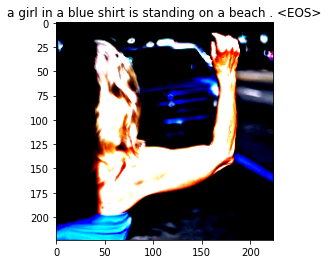

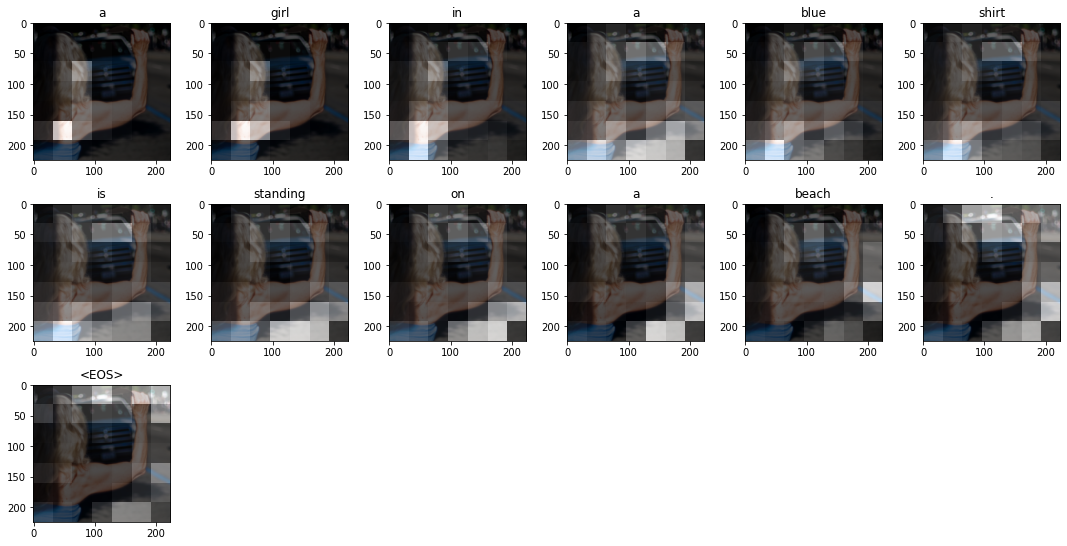

In [25]:
#show any 1
dataiter = iter(train_loader)
images,_ = next(dataiter)

img = images[0].detach().clone()
img1 = images[0].detach().clone()
caps,alphas = get_caps_from(img.unsqueeze(0))

plot_attention(img1, caps, alphas)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


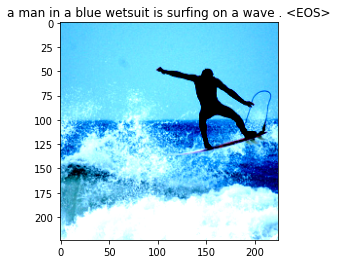

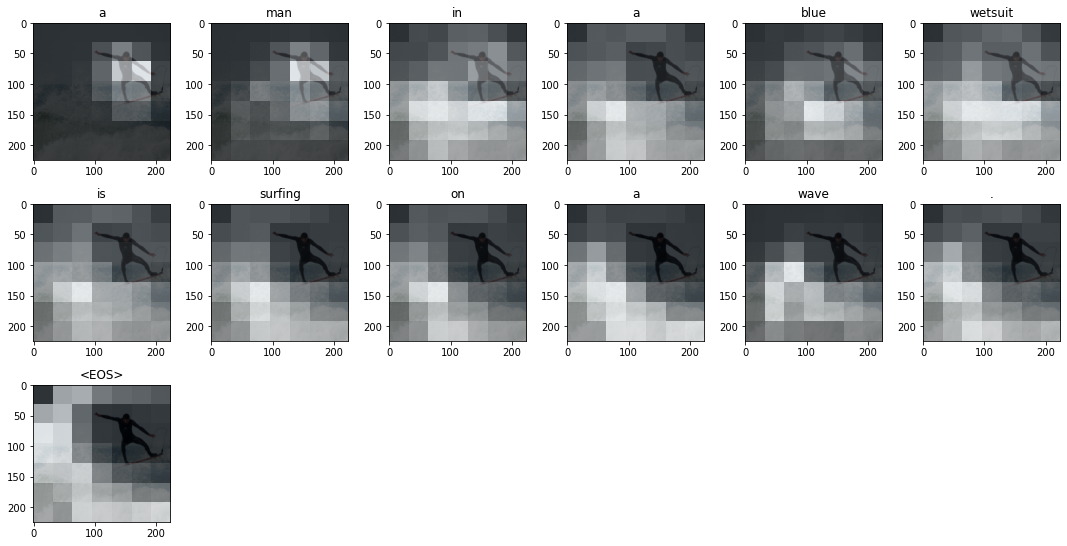

In [27]:
#show any 1
dataiter = iter(train_loader)
images,_ = next(dataiter)

img = images[0].detach().clone()
img1 = images[0].detach().clone()
caps,alphas = get_caps_from(img.unsqueeze(0))

plot_attention(img1, caps, alphas)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


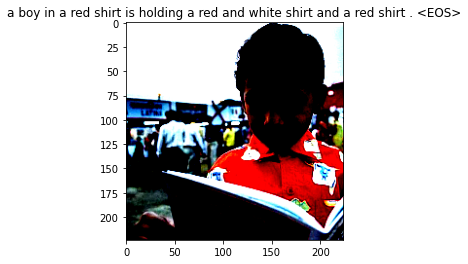

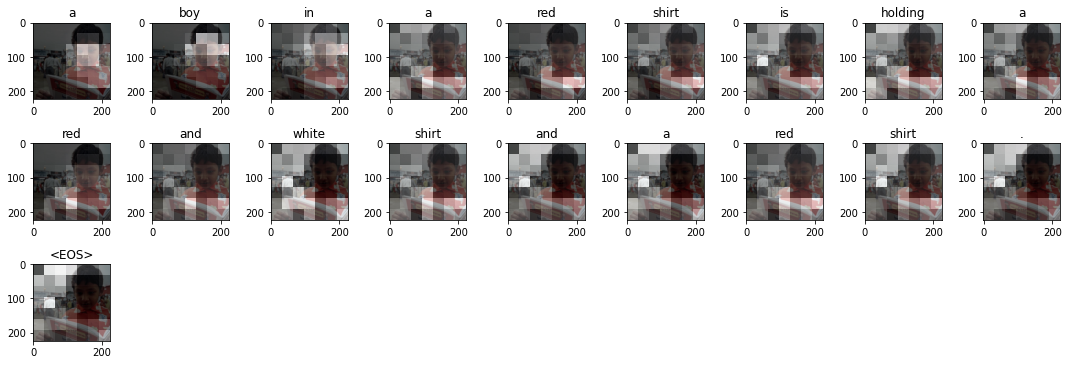

In [28]:
#show any 1
dataiter = iter(train_loader)
images,_ = next(dataiter)

img = images[0].detach().clone()
img1 = images[0].detach().clone()
caps,alphas = get_caps_from(img.unsqueeze(0))

plot_attention(img1, caps, alphas)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


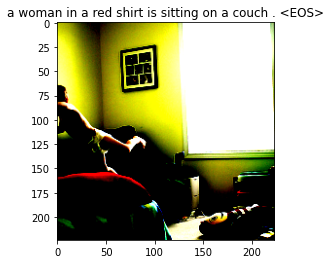

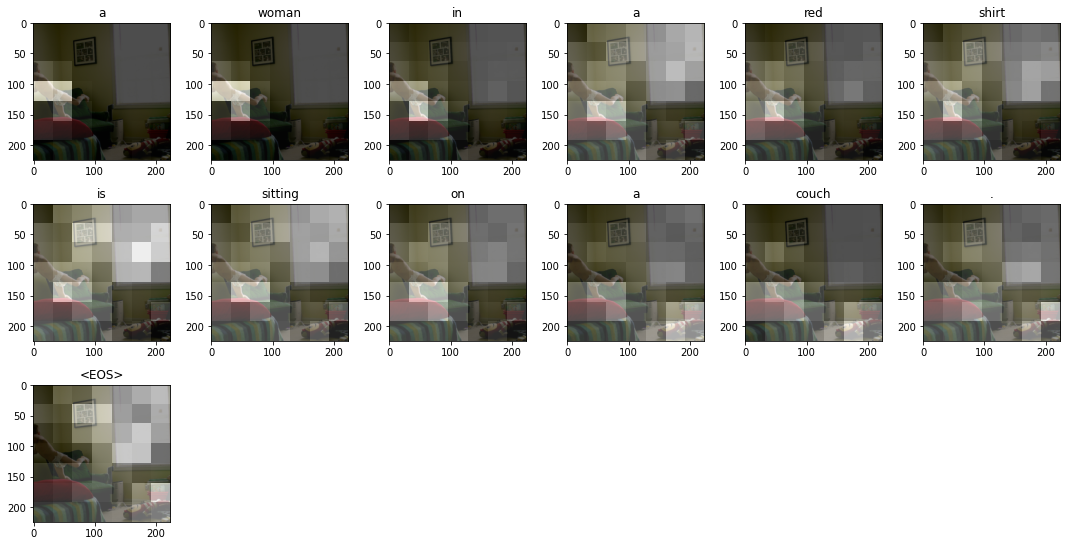

In [29]:
#show any 1
dataiter = iter(train_loader)
images,_ = next(dataiter)

img = images[0].detach().clone()
img1 = images[0].detach().clone()
caps,alphas = get_caps_from(img.unsqueeze(0))

plot_attention(img1, caps, alphas)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


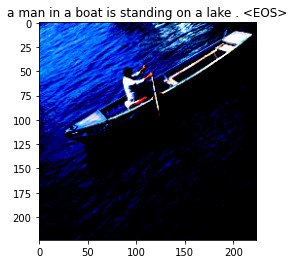

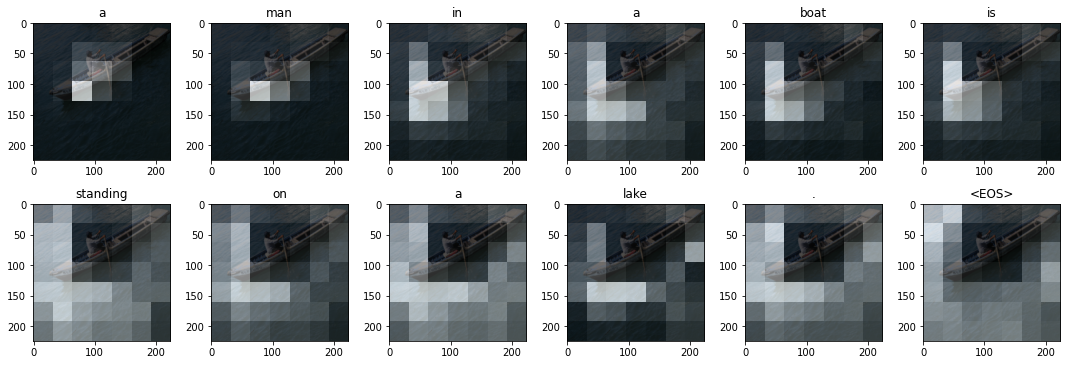

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


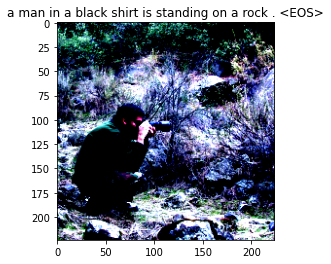

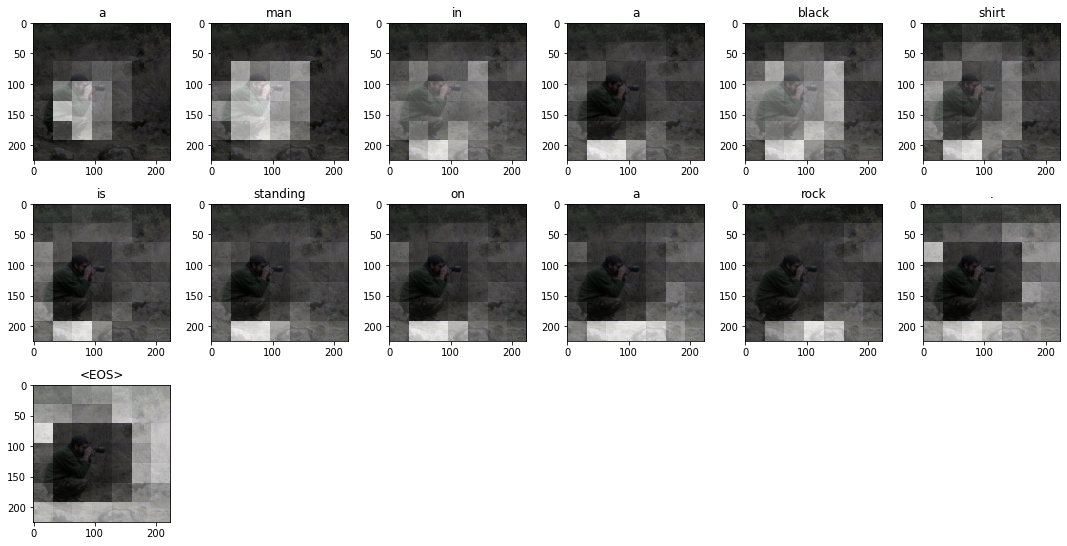

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


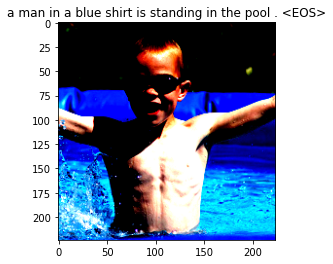

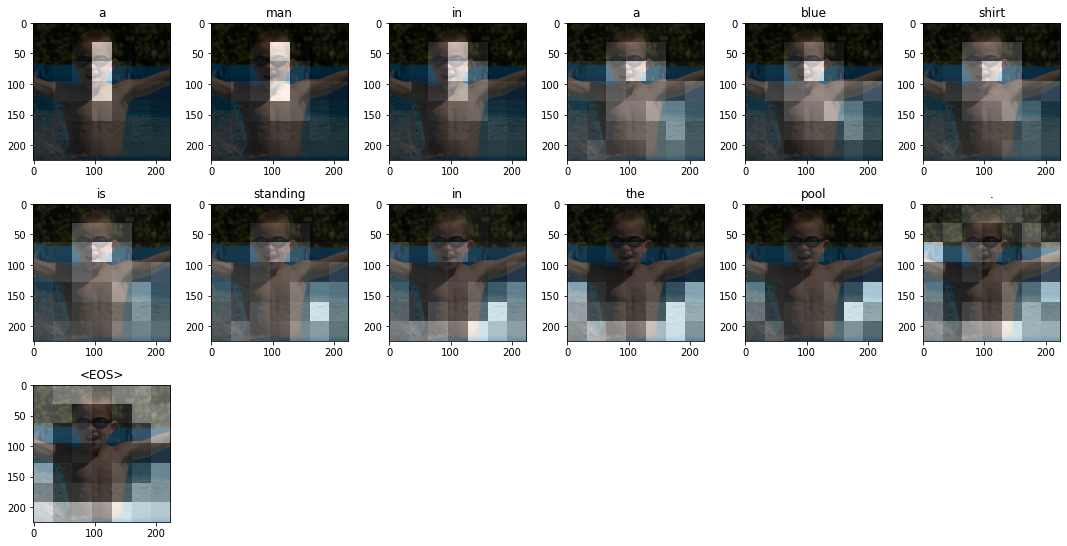

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


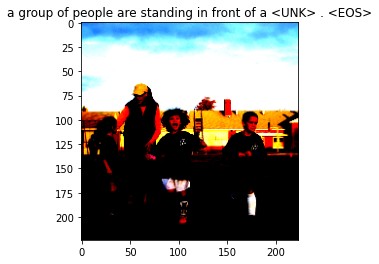

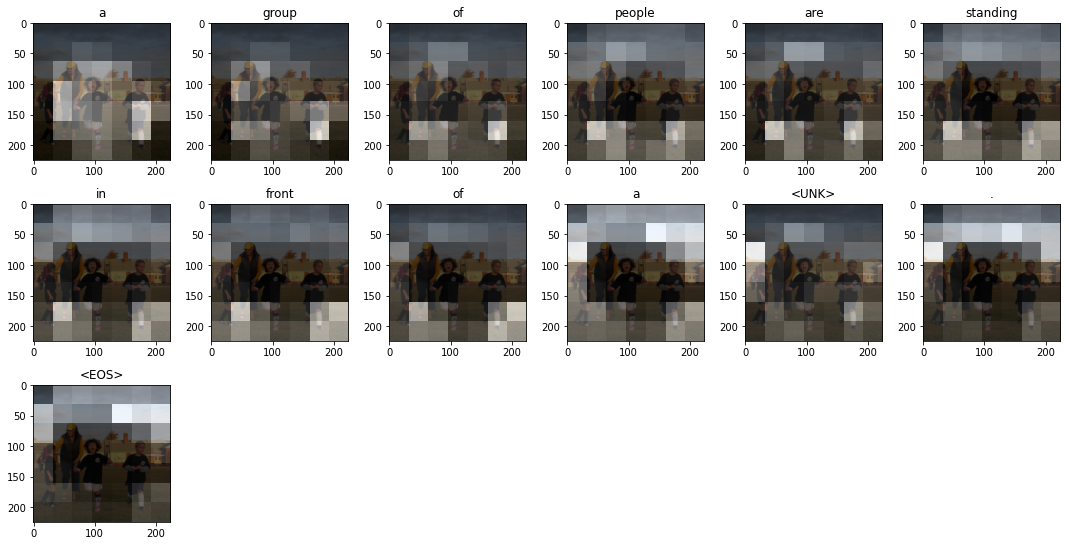

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


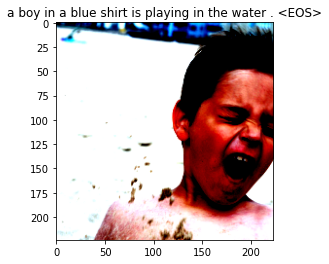

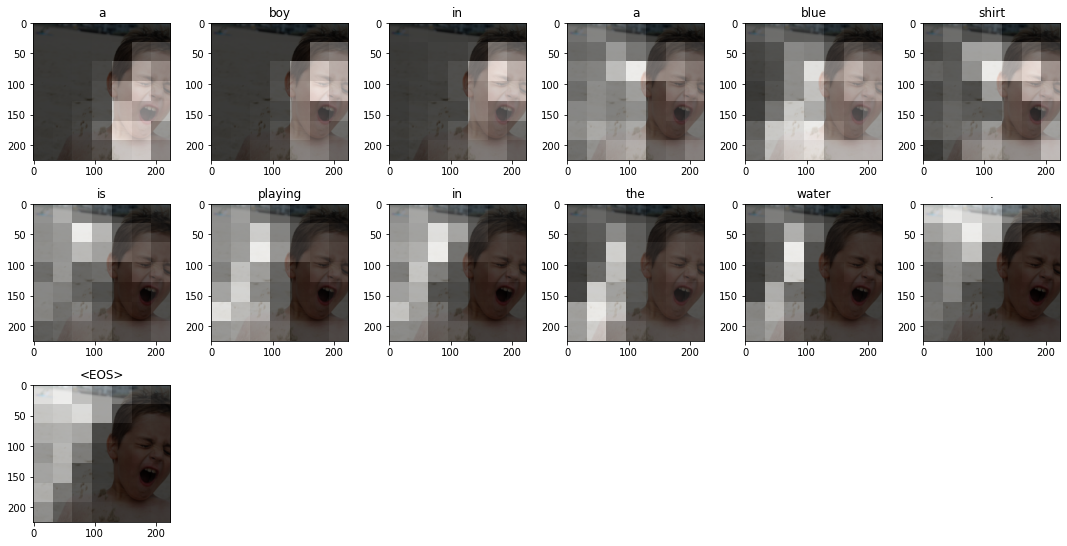

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


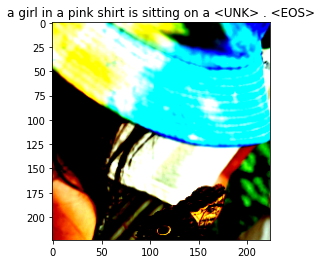

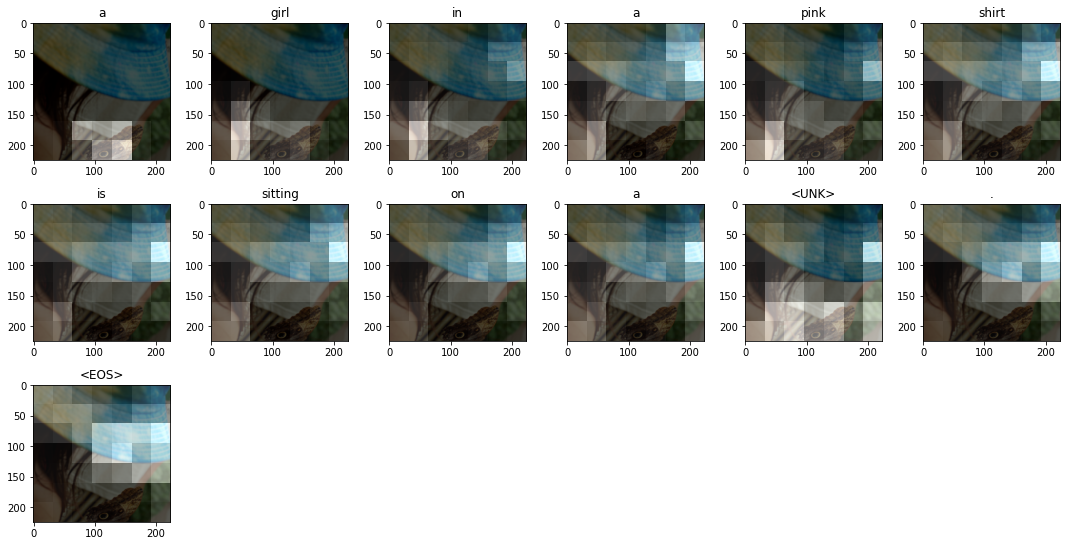

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


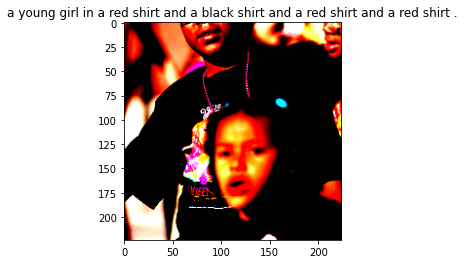

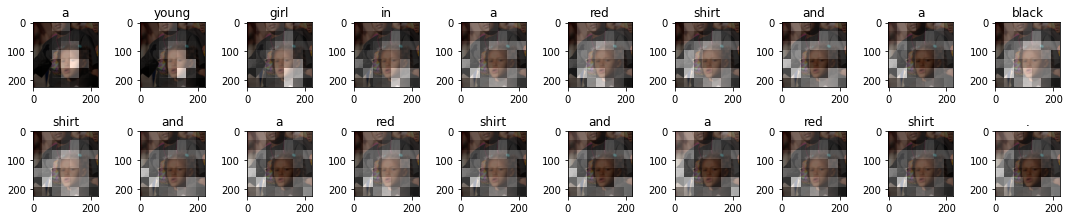

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


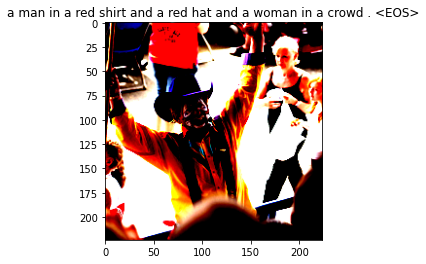

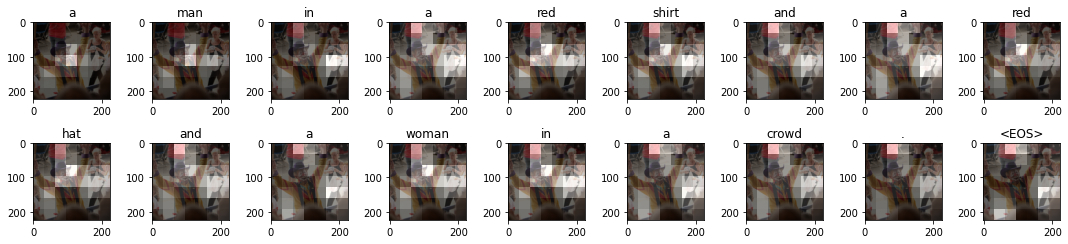

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


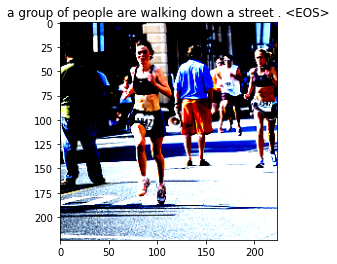

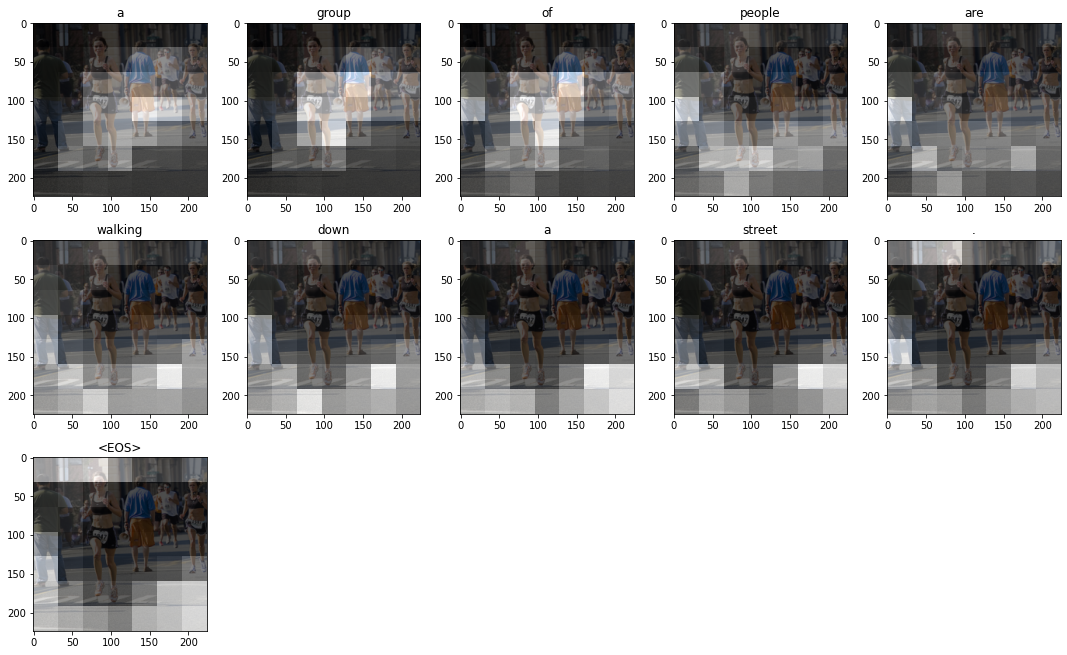

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


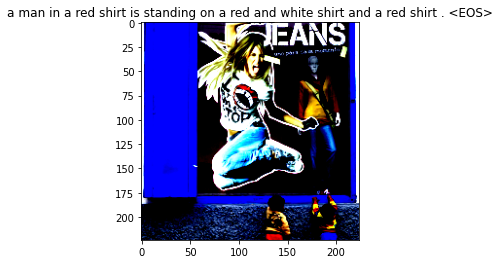

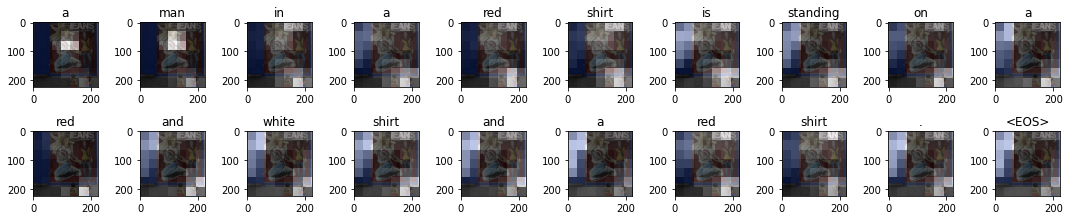

In [30]:
for i in range(10):
    dataiter = iter(train_loader)
    images,_ = next(dataiter)

    img = images[0].detach().clone()
    img1 = images[0].detach().clone()
    caps,alphas = get_caps_from(img.unsqueeze(0))

    plot_attention(img1, caps, alphas)